# Image Captioning

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2021/05/29<br>
**Last modified:** 2021/10/31<br>
**Description:** Implement an image captioning model using a CNN and a Transformer.

## Setup

In [24]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

## Download the dataset

We will be using the Flickr8K dataset for this tutorial. This dataset comprises over
8,000 images, that are each paired with five different captions.

In [25]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [26]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 100
AUTOTUNE = tf.data.AUTOTUNE

## Preparing the dataset

### `load_captions_data`

```python
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data
```

The provided code snippet defines a function `load_captions_data` that is designed to load and preprocess caption data for images, typically used in tasks like image captioning in machine learning. The function reads captions from a specified text file, processes them, and organizes the data into a format suitable for training such models. Here's a breakdown of its functionality:

### Function Definition
- **Purpose**: To load captions data from a text file and map them to their corresponding images.
- **Parameters**: Accepts a single parameter `filename`, which is the path to the text file containing the caption data.
- **Returns**: Two items:
  - `caption_mapping`: A dictionary where each key is an image name, and the value is a list of captions associated with that image.
  - `text_data`: A list containing all the processed captions across all images.

### Core Functionality
1. **Reading Caption Data**: Opens the specified file in read mode and reads all lines, each expected to contain an image name and a caption, separated by a tab.

2. **Data Structures Initialization**:
   - `caption_mapping`: A dictionary to hold the mapping from image names to captions.
   - `text_data`: A list to collect all individual captions after processing.
   - `images_to_skip`: A set to track images that should be skipped due to their captions being too short or too long.

3. **Processing Each Line**:
   - Each line from the file is stripped of the newline character and then split into an image name and a caption based on a tab delimiter.
   - The image name is further processed to remove the caption number suffix and prefixed with a predefined `IMAGES_PATH` directory path.
   - Captions are checked for length to ensure they are not too short (< 5 tokens) or too long (> `SEQ_LENGTH` tokens). Images with such captions are added to `images_to_skip`.

4. **Caption and Image Mapping**:
   - For images not in `images_to_skip`, captions are preprocessed by adding `<start>` and `<end>` tokens at the beginning and end, respectively.
   - The modified caption is added to `text_data`.
   - `caption_mapping` is updated with the image name as key and the list of associated captions as value. If the image name already exists in the dictionary, the new caption is appended to the list of captions; otherwise, a new entry is created.

5. **Removing Skipped Images**: Iterates over `images_to_skip` and removes any entries in `caption_mapping` that correspond to these images, ensuring that only images with appropriately sized captions are included.

### Outcome
- The function prepares the data for image captioning tasks by creating a clean mapping of images to their relevant captions, excluding any captions that do not meet the length criteria. This preprocessing step is crucial for training models on consistent and quality data.

### Key Points
- **Preprocessing Steps**: Adding start and end tokens to captions and excluding captions based on their length are standard preprocessing steps in NLP to improve model performance and manage computational resources effectively.
- **Data Structure Choices**: The choice of a dictionary for `caption_mapping` allows for efficient lookups by image name, while a list for `text_data` provides a simple way to access all captions.

This function exemplifies how to preprocess textual data in the context of a machine learning task, ensuring data quality and consistency before it's used for training.


In [27]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

### `train_val_split`

```python
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data
```

The provided code snippet defines a function `train_val_split` that splits a dataset of image captions into training and validation sets based on a specified proportion. This function is a common utility in machine learning workflows, especially in tasks that involve supervised learning with a fixed dataset, such as image captioning. Below is a detailed explanation of the function's components and its workflow:

### Function Overview

- **Purpose**: To split a dictionary containing image-caption mappings into two separate dictionaries for training and validation purposes.
- **Inputs**:
  - `caption_data`: A dictionary where keys are image names and values are the captions associated with those images.
  - `train_size`: A float indicating the fraction of the dataset to be used as the training set.
  - `shuffle`: A boolean flag indicating whether the dataset should be shuffled before splitting.

### Implementation Details

1. **Extract Image Names**:
   - `all_images = list(caption_data.keys())`: Retrieves all the keys (image names) from the input dictionary and converts them to a list. This list represents the total dataset that will be split into training and validation sets.

2. **Shuffle Dataset (Optional)**:
   - If `shuffle` is True, the function uses `np.random.shuffle(all_images)` to randomly reorder the list of image names. Shuffling is a common practice before splitting a dataset to ensure that the training and validation sets are representative of the overall data distribution.

3. **Calculate Split Index and Partition Dataset**:
   - `train_size = int(len(caption_data) * train_size)`: Calculates the number of items to include in the training set based on the `train_size` fraction. This calculation determines the split index in the list of all images.
   - The dataset is then split into two dictionaries:
     - `training_data`: Contains mappings from the first portion of the shuffled list up to the calculated `train_size` index.
     - `validation_data`: Contains mappings from the remaining portion of the list, starting from the `train_size` index to the end.

4. **Return Training and Validation Datasets**:
   - The function returns two dictionaries: `training_data` and `validation_data`. Each dictionary maintains the original structure of `caption_data` but contains only the subset of data designated for its respective purpose (training or validation).

### Key Considerations

- **Data Integrity**: The function maintains the integrity of the caption-data mappings, ensuring that all captions associated with a given image are either in the training or validation set, but not both.
- **Flexibility**: By allowing the caller to specify the `train_size` and `shuffle` parameters, the function offers flexibility in how the dataset is split, catering to different needs and scenarios in model development and evaluation.
- **Dependency on NumPy**: The function relies on NumPy for shuffling the list of image names. This dependency is common in data science and machine learning projects for its efficiency and ease of use.

### Usage Scenario

This function is particularly useful in the preparation phase of a machine learning project involving image captioning. By splitting the dataset into training and validation sets, it enables the model to be trained on one subset of data and evaluated on a separate, unseen subset, helping to assess the model's generalization ability.

In [28]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [29]:
# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [30]:
type(train_data), type(valid_data)

(dict, dict)

In [31]:
train_data[list(train_data.keys())[0]]

['<start> A woman and two elderly men are standing in front of a speaker . <end>',
 '<start> A woman and two men wearing black jackets . <end>',
 '<start> A woman and two men wearing hats and glassess are standing under a avrovulcan.com sign . <end>',
 '<start> A woman and two older gentlemen who are both wearing hats . <end>',
 '<start> Three older people stand in front of an avrovulcan.com sign . <end>']

In [32]:
type(captions_mapping), list(captions_mapping.keys())[0]

(dict, 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg')

## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).

### `custom_standardization`

```python
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
```

The provided code snippet defines a function `custom_standardization` that applies a custom text standardization process using TensorFlow operations. Text standardization is a common preprocessing step in natural language processing (NLP) tasks that involves converting text to a more uniform format. This function specifically performs two operations: converting all characters in the input string to lowercase and removing certain characters specified by `strip_chars`. Here's a breakdown of the function:

### Function Overview

- **Purpose**: To standardize text data by converting it to lowercase and removing specified characters.
- **Input**:
  - `input_string`: A TensorFlow string tensor representing the text to be standardized.
- **Output**:
  - The function returns a TensorFlow string tensor that has been converted to lowercase and had specified characters removed.

### Implementation Details

1. **Convert to Lowercase**:
   - `lowercase = tf.strings.lower(input_string)`: This line uses TensorFlow's `tf.strings.lower` method to convert all characters in `input_string` to lowercase. This step ensures that the case of the letters does not affect text processing, making it more consistent.

2. **Remove Specified Characters**:
   - `return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")`: This line performs character removal. It uses `tf.strings.regex_replace`, a TensorFlow method that applies a regular expression replacement.
   - The regular expression `[%s]` is constructed dynamically using `re.escape(strip_chars)`. `strip_chars` is a variable not defined within this snippet but is assumed to be a string containing characters that should be removed from the input text. `re.escape` is a function from the Python `re` (regular expressions) module that escapes all characters in `strip_chars`. This means that any special characters that might have special meanings in regular expressions are treated as literal characters.
   - The `[%s]` pattern matches any single character that is found in `strip_chars`, and these characters are replaced with an empty string (`""`), effectively removing them from the `lowercase` string.

### Key Points

- **TensorFlow Operations**: The function leverages TensorFlow's string manipulation operations, making it suitable for preprocessing text data within TensorFlow pipelines. This allows for direct integration with TensorFlow datasets and models, facilitating efficient processing on GPUs or TPUs.
- **Regular Expressions**: By using regular expressions for character removal, the function offers flexibility in specifying which characters to strip from the text, allowing it to be easily adapted for various text cleaning tasks.
- **Variable `strip_chars`**: The `strip_chars` variable must be defined outside this function or passed as an argument for the function to work as intended. It should contain all characters that need to be removed from the input text, making the function highly customizable.

### Usage Scenario

This function is particularly useful in preprocessing stages of NLP projects where text data needs to be cleaned and standardized before being fed into a model. Standardizing text by converting it to lowercase and removing unnecessary or unwanted characters can help reduce the complexity of the model's input space and improve its performance on text-related tasks.

In [33]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [34]:
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

In [35]:
vectorization.adapt(text_data)

```python
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)
```

The provided code snippet defines an image augmentation pipeline using Keras, a high-level neural networks API running on top of TensorFlow. Image augmentation is a technique used to artificially expand the size of a training dataset by applying various transformations to the images. This process helps prevent overfitting and allows the model to generalize better to new, unseen images by providing a more diverse set of training examples. Here's a detailed explanation of the code:

### Code Overview

- **Purpose**: To create an image augmentation pipeline that applies random transformations to image data during training.
- **Components**:
  - `keras.Sequential`: This constructs a sequential model. In the context of data augmentation, the sequential model is used to define a pipeline of image transformations that are applied in sequence to the input images.
  - `layers.RandomFlip("horizontal")`: This layer applies random horizontal flips to the images. Flipping the image horizontally (mirroring it along the vertical axis) is a common augmentation technique for image data, as it simulates the variation that might be seen in real-world scenarios.
  - `layers.RandomRotation(0.2)`: This layer randomly rotates the images by a factor of 0.2. The rotation factor is a fraction of 360 degrees, meaning that in this case, each image will be randomly rotated between -36 degrees and +36 degrees. This adds rotational variation to the training data.
  - `layers.RandomContrast(0.3)`: This layer randomly adjusts the contrast of the images by a factor of 0.3. This can make the images slightly darker or lighter, which helps the model learn to recognize patterns under various lighting conditions.

### Key Points

- **Data Augmentation**: The augmentation techniques used here (flipping, rotation, and contrast adjustment) are non-destructive and widely applicable to many types of image data, making them a good starting point for general image classification tasks.
- **Randomization**: Each transformation is applied randomly to each image in the dataset. This means that during training, the model sees slightly different versions of each training image, which helps it learn more robust features.
- **Sequential Model for Augmentation**: Using `keras.Sequential` for defining an augmentation pipeline is a convenient way to compose multiple image transformations. It allows for easy experimentation with different augmentation strategies by adding or removing layers.

### Usage Scenario

This image augmentation pipeline can be integrated into a training workflow in Keras. When preparing the dataset for training, the augmentation model can be applied to the training data but typically not to the validation or test data. Applying augmentation to training data helps improve the model's ability to generalize, while the validation and test data should remain unaltered to accurately evaluate how well the model performs on unmodified images.

In [36]:
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image

### `decode_and_resize`

```python
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img
```

The provided code snippet defines a function `decode_and_resize` that processes an image from its file path to a format suitable for feeding into a machine learning model. This function performs several steps using TensorFlow operations to read the image file, decode it, resize it, and adjust its pixel value data type. Below is a detailed explanation of each step in the function:

### Function Overview

- **Purpose**: To read an image from a given file path, decode it from JPEG format, resize it to a specified size, and convert its pixel values to a floating-point data type.
- **Input**:
  - `img_path`: A string representing the path to the image file to be processed.
- **Output**:
  - The function returns the processed image tensor, ready for use in a machine learning model.

### Implementation Details

1. **Read Image File**:
   - `img = tf.io.read_file(img_path)`: This line uses TensorFlow's `tf.io.read_file` function to read the raw contents of the image file specified by `img_path`. The result, `img`, is a tensor containing the raw byte values of the image.

2. **Decode JPEG Image**:
   - `img = tf.image.decode_jpeg(img, channels=3)`: The raw bytes are then decoded from JPEG format into an image tensor using `tf.image.decode_jpeg`. The `channels=3` argument specifies that the image is decoded with three color channels (RGB), ensuring the image is in color.

3. **Resize Image**:
   - `img = tf.image.resize(img, IMAGE_SIZE)`: The decoded image tensor is resized to `IMAGE_SIZE`, where `IMAGE_SIZE` is expected to be a tuple or list specifying the new height and width of the image. Resizing is a common preprocessing step to ensure that all images fed into a model are of the same dimension.

4. **Convert Image Data Type**:
   - `img = tf.image.convert_image_dtype(img, tf.float32)`: Finally, the function converts the pixel values of the image from their original data type (likely uint8, with values in the range [0, 255]) to a floating-point data type (`tf.float32`). This conversion typically normalizes the pixel values to the range [0, 1], making them more suitable for processing by neural networks, which often perform better with input data in this normalized range.

### Key Points

- **Data Preprocessing for Machine Learning**: The function encapsulates common preprocessing steps required to prepare image data for training or inference with machine learning models, especially convolutional neural networks (CNNs) used in image tasks.
- **TensorFlow Operations**: It leverages TensorFlow's image processing functions, allowing these operations to be integrated into a TensorFlow data pipeline efficiently. This integration supports batch processing and GPU acceleration, which can significantly speed up preprocessing when working with large image datasets.
- **Flexibility**: While the function is tailored for JPEG images with three color channels, similar patterns can be adapted for images in other formats or with different channel requirements by modifying the decode function and `channels` argument.

In [37]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

### `process_input`

```python
def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)
```

The `process_input` function is designed to prepare both image and textual data for a machine learning model, particularly in tasks that involve processing images alongside their corresponding textual descriptions, such as image captioning. It takes an image file path and a list of captions as inputs and applies specific processing steps to both, leveraging previously defined functions `decode_and_resize` for the image and `vectorization` for the captions. Here's a closer look at the function, its implementation details, and key points:

### Function Overview

- **Purpose**: To process an image file and its associated captions in preparation for training or inference with a machine learning model. This involves decoding, resizing, and normalizing the image, as well as vectorizing the captions.
- **Inputs**:
  - `img_path`: A string representing the file path to an image.
  - `captions`: A list of textual captions associated with the image.
- **Output**: A tuple containing two elements:
  - The processed image, which has been decoded, resized, and normalized.
  - The vectorized captions, converted from text to a numerical representation suitable for model processing.

### Implementation Details

1. **Image Processing (`decode_and_resize`)**:
   - `decode_and_resize(img_path)`: This call processes the image at the specified file path. The `decode_and_resize` function is expected to read the image file, decode it from its file format (e.g., JPEG) into a tensor, resize it to a specified dimension (`IMAGE_SIZE`), and normalize the pixel values. The exact resizing dimensions and normalization behavior would be defined within the `decode_and_resize` function itself.
   
2. **Text Processing (`vectorization`)**:
   - `vectorization(captions)`: This call processes the textual captions. The `vectorization` function or operation is expected to convert the list of textual captions into a numerical format (e.g., sequences of integers or embeddings) that a machine learning model can process. This might involve tokenizing the text, mapping tokens to integers based on a vocabulary, and possibly padding or truncating sequences to a uniform length.

### Key Points

- **Dual Data Processing**: The function handles the preprocessing of both image and text data, reflecting a common pattern in multimodal machine learning tasks where models are trained on datasets comprising different types of data (e.g., images and their textual descriptions).
- **Separation of Concerns**: By delegating the specifics of image and text processing to `decode_and_resize` and `vectorization`, respectively, `process_input` maintains a clean separation of concerns. This makes the code modular and easier to maintain, as changes to image or text preprocessing can be made independently.
- **Flexibility and Reusability**: The function is designed to be flexible and reusable across different datasets and tasks that require similar preprocessing steps. The abstraction away from specific preprocessing details allows it to be applied in various contexts where the input data format aligns with the expected inputs of `decode_and_resize` and `vectorization`.

### Usage Scenario

`process_input` is ideally suited for use in data pipelines for machine learning models that operate on datasets containing images and their corresponding captions. It can be used to preprocess batches of data before feeding them into the model for training or inference, ensuring that the data is in the correct format and state for the model to process effectively.

In [38]:
def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

### `make_dataset`

```python
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset
```

The `make_dataset` function is designed to create a TensorFlow dataset from lists or arrays of images and their corresponding captions, applying preprocessing, shuffling, batching, and prefetching to optimize the data pipeline for training a machine learning model. Here's a detailed look at the function, its implementation, and key points:

### Function Overview

- **Purpose**: To construct a TensorFlow dataset that is ready for use in training or evaluating a machine learning model, specifically one that deals with images and textual data simultaneously.
- **Inputs**:
  - `images`: A list or array of image file paths.
  - `captions`: A list or array of textual captions corresponding to each image.
- **Output**:
  - A `tf.data.Dataset` object that yields batches of preprocessed images and captions, ready for model consumption.

### Implementation Details

1. **Creating the Dataset**:
   - `tf.data.Dataset.from_tensor_slices((images, captions))`: This line creates a TensorFlow dataset from the input images and captions. `from_tensor_slices` constructs a dataset where each element is a tuple consisting of an image file path and its corresponding caption.

2. **Shuffling the Dataset**:
   - `dataset.shuffle(BATCH_SIZE * 8)`: The dataset is shuffled to ensure that the data is fed to the model in a random order. This helps prevent the model from learning any unintended order patterns from the data, which can be beneficial for generalization. The shuffle buffer size is set to `BATCH_SIZE * 8`, which is a common heuristic to balance between randomness and performance.

3. **Applying Preprocessing**:
   - `dataset.map(process_input, num_parallel_calls=AUTOTUNE)`: This line applies the `process_input` function to each element (image, caption pair) in the dataset. The `process_input` function is expected to perform necessary preprocessing steps, such as decoding and resizing images and vectorizing captions. `num_parallel_calls=AUTOTUNE` allows TensorFlow to dynamically determine the optimal number of parallel calls to use for mapping, improving data loading performance.

4. **Batching and Prefetching**:
   - `dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)`: This line first batches the dataset into batches of size `BATCH_SIZE`, making it suitable for training models that expect batched input. Then, `prefetch(AUTOTUNE)` is used to prefetch batches while the model is training on the current batch. This overlapping of data preprocessing and model execution can significantly improve training efficiency. `AUTOTUNE` allows TensorFlow to automatically adjust the prefetch buffer size for optimal performance.

### Key Points

- **Optimized Data Pipeline**: The function demonstrates how to efficiently prepare a dataset for training a model, incorporating best practices such as shuffling, batching, and prefetching.
- **Modular Preprocessing**: By using the `process_input` function within `dataset.map`, it abstracts away the specifics of data preprocessing, making the pipeline flexible and adaptable to changes in preprocessing requirements.
- **Dynamic Performance Tuning**: The use of `AUTOTUNE` in both mapping and prefetching operations enables dynamic adjustment of parallelism and prefetching, allowing TensorFlow to optimize these settings based on the runtime environment.

### Usage Scenario

`make_dataset` is particularly useful in scenarios where a model is trained or evaluated on image-caption pairs, such as in image captioning tasks, visual question answering, or any multimodal learning context. By efficiently handling both image and text data within a unified dataset object, it streamlines the process of feeding data into the model, allowing for more focus on model architecture and training dynamics.

In [39]:
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

In [40]:
# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
print("Done with training data")
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))
print("Done with validation data")

Done with training data
Done with validation data


### Investigate One Sample

In [41]:
type(train_dataset), len(train_dataset)

(tensorflow.python.data.ops.prefetch_op._PrefetchDataset, 96)

In [42]:
for this_batch in train_dataset.take(1):
    tmp_images, tmp_texts = this_batch
    break

In [43]:
type(tmp_images), tmp_images.shape, type(tmp_texts), len(tmp_texts)

(tensorflow.python.framework.ops.EagerTensor,
 TensorShape([64, 299, 299, 3]),
 tensorflow.python.framework.ops.EagerTensor,
 64)

In [44]:
i = 0
curr_img = tmp_images[i]
curr_text = tmp_texts[i]

In [45]:
curr_img.shape, curr_text

(TensorShape([299, 299, 3]),
 <tf.Tensor: shape=(5, 25), dtype=int64, numpy=
 array([[   3,    2,  396,    9,  410,    7,    2,   61,  680,   78,  209,
          115,    2,  145,  908,  152,    4,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   3,    2,   12,  130,    2,  142,   36,    2,   27,   20,  127,
          240,    6,  158,   13,  156,    4,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   3,    2,   27,   20,    8,   38,    7,    6,  158,   13,    2,
           12,  148,  142,   36,    6,   12, 6436, 1115,    4,    0,    0,
            0,    0,    0],
        [   3,   12,    7,   78,   11,  410,   38,    7, 1470,   13,  158,
           11,  225,   99,   30,  730,    4,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   3,   61,  267,    8, 4136,   72,    7,   30,   78,    4,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]])>)

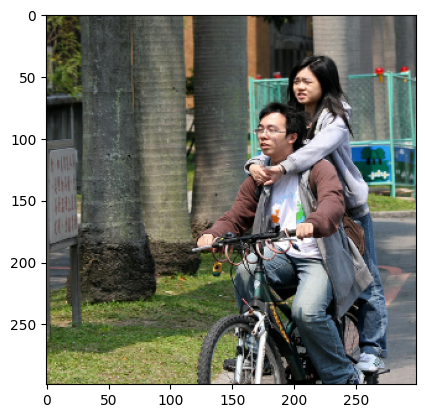

In [46]:
plt.imshow(np.round(curr_img).astype(int))

## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
                    based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data
                    (sequences) as inputs and tries to learn to generate the caption.

In [47]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

### `TransformerEncoderBlock`

```python
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1
```

The `TransformerEncoderBlock` class defines a custom layer in TensorFlow that implements a simplified version of a transformer encoder block, commonly used in transformer models for tasks like natural language processing. The constructor of the class initializes the block with an embedding dimension (`embed_dim`), a dense layer dimension (`dense_dim`), and the number of attention heads (`num_heads`). Within the block, it employs a multi-head attention mechanism (`layers.MultiHeadAttention`) for processing sequences in parallel across multiple heads, improving the model's ability to capture different types of dependencies in the data. It also uses two layer normalization steps (`layers.LayerNormalization`) to stabilize the outputs of the network layers. Additionally, a dense layer with ReLU activation (`layers.Dense`) is included to allow for non-linear transformations of the data. In the `call` method, the input data is first normalized and then passed through the dense layer, followed by the attention mechanism, and finally normalized again before being output. This structure enables the transformer encoder block to learn complex representations of the input data, which is crucial for the performance of transformer models.

In [48]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

### `PositionalEmbedding`

```python
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
```

The `PositionalEmbedding` class implements a custom TensorFlow layer for generating embeddings that combine both token and positional information, a concept integral to the architecture of transformer models. This layer is designed to encode the position of tokens within a sequence, in addition to the semantic information captured by traditional token embeddings. The constructor initializes the layer with the maximum sequence length (`sequence_length`), vocabulary size (`vocab_size`), and embedding dimension (`embed_dim`). It creates two separate embedding layers: one for the tokens (`token_embeddings`) and another for their positions within a sequence (`position_embeddings`). The embeddings are scaled by the square root of the embedding dimension to normalize their magnitude. In the `call` method, for a given input sequence, the layer computes token embeddings and scales them, generates positional indices, and then retrieves positional embeddings. These two embeddings are summed to produce the final output, which contains information about both the identity of tokens and their positions in the sequence. Additionally, the `compute_mask` method generates a mask to indicate the presence of non-zero tokens, which is useful for handling variable-length sequences in batched inputs, ensuring that padding tokens do not affect the model's calculations.

In [49]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

### `TransformerDecoderBlock`

```python
class TransformerDecoderBLock():
    def __init__():
        #TODO
    
    def call():
        #TODO
    
    def get_causal_attention_mask():
        #TODO
```

In the `__init__` method of the `TransformerDecoderBlock` class, a custom TensorFlow layer is initialized, representing a decoder block commonly found in transformer models. This block is designed to handle the complexities of sequence generation tasks, such as language modeling or machine translation. It initializes with an embedding dimension (`embed_dim`), a feed-forward network dimension (`ff_dim`), and the number of attention heads (`num_heads`). The block comprises two multi-head attention layers, two feed-forward neural network (FFN) layers, three layer normalization steps, and an output dense layer with softmax activation for generating predictions over a vocabulary. The first attention layer is self-attention, allowing the decoder to focus on different parts of the input sequence. The second attention layer focuses on the encoder outputs, enabling the decoder to incorporate information from the input sequence. Dropout layers are also included to prevent overfitting, and the block supports masking to handle variable-length sequences efficiently.

The `call` method of the `TransformerDecoderBlock` handles the forward pass through the decoder block. It begins by applying positional embeddings to the input sequence, which is crucial for maintaining the order of the sequence in the absence of recurrence. The method then constructs a causal mask to ensure that predictions for a given position can only depend on known outputs at earlier positions in the sequence (i.e., to prevent "looking ahead"). This is combined with any additional padding mask provided to handle variable-length sequences. The method processes the sequence through the self-attention layer, followed by cross-attention with the encoder outputs, applying layer normalization after each attention step. The output then passes through two FFN layers, with dropout applied for regularization, and a final dense layer that generates the probability distribution over the vocabulary for each sequence position. This structure allows the decoder to generate sequences based on the context provided by both the input sequence and the sequence it has generated so far.

The `get_causal_attention_mask` method generates a mask to enforce causal attention in the self-attention mechanism of the decoder. This mask is used to prevent the decoder from accessing future tokens in the sequence, a requirement for autoregressive models where the prediction for each token can only depend on previously generated tokens. The method constructs a square matrix where the value at position $(i, j)$ is 1 if $i >= j$ and 0 otherwise, ensuring that for any position in the sequence, only positions up to and including the current one are considered. This matrix is then tiled across the batch dimension to create a mask compatible with the batch size and sequence length of the input. By applying this mask during the self-attention operation, the model adheres to the autoregressive property, making it suitable for tasks like text generation where the order of token generation is crucial.

In [50]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)

### `ImageCaptioningModel`

```python
class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        #TODO

    def calculate_loss(self, y_true, y_pred, mask):
        #TODO

    def calculate_accuracy(self, y_true, y_pred, mask):
        #TODO

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        #TODO

    def train_step(self, batch_data):
        #TODO

    def test_step(self, batch_data):
        #TODO

    @property
    def metrics(self):
        #TODO

```

In the `__init__` method of the `ImageCaptioningModel` class, which inherits from `keras.Model`, the model is initialized with several components essential for image captioning tasks. These components include a CNN model (`cnn_model`) for image feature extraction, an encoder and decoder for processing the image features and generating captions, respectively, and optionally, an image augmentation pipeline (`image_aug`). The model also initializes trackers for monitoring the loss (`loss_tracker`) and accuracy (`acc_tracker`) during training and evaluation. The number of captions per image (`num_captions_per_image`) is specified to handle datasets where multiple captions are available for a single image, allowing the model to learn from a richer set of annotations.

The `calculate_loss` method computes the loss for a batch of predicted captions against the true captions, taking into account a mask that ignores padding tokens. This method multiplies the loss by the mask (converting the mask to the same dtype as the loss), ensuring that only the non-padded parts of the captions contribute to the loss calculation. The loss is then summed up and normalized by the sum of the mask, providing a scalar value that represents the average loss across all tokens that are relevant for training.

The `calculate_accuracy` method computes the accuracy of the predicted captions by comparing the predicted tokens (using `argmax` to select the most probable token predictions) with the true tokens. The comparison results in a boolean tensor that is masked to exclude padding tokens, ensuring accuracy is only computed for relevant tokens. The boolean tensor is cast to `float32` for calculation, and accuracy is obtained by summing the true predictions and normalizing by the sum of the mask, similar to the loss calculation.

The `_compute_caption_loss_and_acc` method orchestrates the computation of loss and accuracy for a single batch of image-caption pairs. It first generates image embeddings using the encoder, then slices the caption sequences to separate inputs from targets, applies a mask to ignore padding, and finally passes these to the decoder. The method returns the calculated loss and accuracy for the batch, encapsulating the forward pass and evaluation metrics computation in a single step.

During the `train_step`, the method processes a batch of images and their associated captions. If image augmentation is specified, it is applied to the images first. Then, for each caption associated with an image, it computes the loss and accuracy, updates the model's weights using gradient descent, and accumulates the batch's total loss and accuracy. This process is repeated for each caption, allowing the model to learn from multiple annotations per image. The method concludes by updating the loss and accuracy trackers with the batch's average values and returns these metrics.

The `test_step` method is similar to `train_step` but is used for evaluating the model on a validation or test set without performing any weight updates. It computes the loss and accuracy for each caption in a batch of images and captions, aggregates these metrics across all captions, and updates the loss and accuracy trackers. This method ensures that the model's performance is evaluated consistently with how it was trained, taking into account multiple captions per image.

Finally, the `metrics` property ensures that the custom loss and accuracy trackers are recognized as part of the model's metrics. This allows Keras to automatically reset their states at the start of each epoch during training and evaluation, ensuring that metrics are reported correctly for each epoch and do not accumulate state across epochs. This setup is crucial for monitoring the model's performance over time and making adjustments to training as needed.

In [51]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [52]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

## Model training

```python
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction="auto",
)
```

The code snippet defines a loss function named `cross_entropy` using Keras's built-in `SparseCategoricalCrossentropy` class. This particular loss function is used for classification tasks where the classes are mutually exclusive (i.e., each sample belongs to one of `C` classes). The `SparseCategoricalCrossentropy` computes the cross-entropy loss between the labels and predictions. The key parameters used here are `from_logits=False`, indicating that the predictions provided to the loss function are probabilities (and not the raw outputs from the network, which are logits), and `reduction="auto"`, which specifies that the reduction method to aggregate individual losses into a scalar loss value is automatically determined.

The mathematical formula for sparse categorical cross-entropy, given the predictions are probabilities (due to `from_logits=False`), is:

$$
L = -\frac{1}{N} \sum_{i=1}^{N} \log(p_{y_i})
$$

where:
- $L$ is the loss calculated over all $N$ samples in the batch.
- $p_{y_i}$ is the predicted probability of the true class $y_i$ for the $i$-th sample.
- $\log$ is the natural logarithm.

This formula calculates the negative logarithm of the predicted probability assigned to the true class for each sample and averages these values over all samples in the batch. The "sparse" aspect refers to the fact that the labels are expected to be provided as integers (the class indices), as opposed to one-hot encoded arrays, making it more memory efficient for classification problems with a large number of classes.


In [53]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction="auto",
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

### `LRSchedule`


```python
# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )
```

The code defines a custom learning rate scheduler named `LRSchedule`, which inherits from Keras's `LearningRateSchedule`. This scheduler implements a learning rate warmup strategy, where the learning rate gradually increases from 0 to a predefined value (`post_warmup_learning_rate`) over a certain number of steps (`warmup_steps`) before stabilizing at that value for the rest of the training. The purpose of such a strategy is to modulate the learning rate dynamically during training, with specific behavior during the initial phase, known as the warmup period.

In the `__init__` method, the scheduler is initialized with two key parameters: `post_warmup_learning_rate`, which is the learning rate to be used after the warmup period, and `warmup_steps`, which defines the length of the warmup period in terms of the number of training steps.

The `__call__` method is responsible for calculating the learning rate for the current step during training. It casts the current step and the warmup steps to floats for computation. Then, it calculates the progress of the warmup by dividing the current step number by the total number of warmup steps, resulting in a fraction that represents how far along the warmup process is. This fraction is then multiplied by the `post_warmup_learning_rate` to calculate a gradually increasing learning rate during the warmup period. Finally, the `tf.cond` function is used to decide whether to return this increasing learning rate (if the current step is less than the total warmup steps) or the `post_warmup_learning_rate` (if the warmup period has concluded).

The theory behind warmup steps in learning rate scheduling is based on the idea that starting the training with a smaller learning rate can help the model gradually adapt to the landscape of the loss function, potentially leading to better convergence. A too-large initial learning rate can cause the model parameters to adjust too rapidly, leading to instability or divergence in the early stages of training. As the model becomes more stable and starts converging, the learning rate can be increased to speed up training. After the warmup period, maintaining a constant learning rate (or applying other forms of learning rate decay) can help in fine-tuning the model's weights to reach the optimal solution. Warmup is particularly useful in training deep neural networks and is a common practice in training large-scale models, such as transformers in natural language processing tasks.

#### Technical Discussion of Learning Rate Scheduler

Certainly, the mathematical formulation of a learning rate schedule with warmup can be described using the following equation:

$$
lr(t) =
\begin{cases}
  \left( \frac{t}{warmup\_steps} \right) \times post\_warmup\_learning\_rate & \text{if } t < warmup\_steps \\
  post\_warmup\_learning\_rate & \text{otherwise}
\end{cases}
$$

where:
- $lr(t)$ is the learning rate at step $t$.
- $t$ is the current training step.
- $warmup\_steps$ is the total number of steps during which the learning rate is increased linearly.
- $post\_warmup\_learning\_rate$ is the learning rate after the warmup phase.

During the warmup phase ($t < warmup\_steps$), the learning rate $lr(t)$ increases linearly with the step $t$, starting from 0 at $t = 0$ and reaching $post\_warmup\_learning\_rate$ at $t = warmup\_steps$. After the warmup phase ($t \geq warmup\_steps$), the learning rate remains constant at $post\_warmup\_learning\_rate$. This approach allows the model to start with small parameter updates and gradually increase the size of the updates, helping to stabilize the training process in the early stages.

In [54]:
# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

In [55]:
# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/100
96/96 [==============================] - 117s 930ms/step - loss: 32.6363 - acc: 0.0883 - val_loss: 23.2482 - val_acc: 0.2526
Epoch 2/100
96/96 [==============================] - 70s 727ms/step - loss: 21.0025 - acc: 0.2835 - val_loss: 18.8465 - val_acc: 0.3364
Epoch 3/100
96/96 [==============================] - 70s 723ms/step - loss: 18.1658 - acc: 0.3415 - val_loss: 17.3243 - val_acc: 0.3604
Epoch 4/100
96/96 [==============================] - 70s 728ms/step - loss: 16.8014 - acc: 0.3645 - val_loss: 16.5495 - val_acc: 0.3751
Epoch 5/100
96/96 [==============================] - 69s 718ms/step - loss: 15.8680 - acc: 0.3805 - val_loss: 15.9938 - val_acc: 0.3866
Epoch 6/100
96/96 [==============================] - 70s 724ms/step - loss: 15.1571 - acc: 0.3957 - val_loss: 15.6657 - val_acc: 0.3938
Epoch 7/100
96/96 [==============================] - 69s 716ms/step - loss: 14.5626 - acc: 0.4082 - val_loss: 15.4167 - val_acc: 0.3990
Epoch 8/100
96/96 [============================

## Check sample predictions

### `generate_caption`

```python
def generate_caption():
    #TODO
```

The `generate_caption` function demonstrates an end-to-end process for generating captions for randomly selected images from a validation dataset using a pre-trained image captioning model. Initially, it selects a random image and preprocesses it through the `decode_and_resize` function, which likely decodes the image from its file format and resizes it to a specific dimension expected by the model. This preprocessed image is then displayed using `matplotlib`. Subsequently, the image is passed through a convolutional neural network (CNN) model to extract feature representations. These features are then fed into a Transformer encoder to encode the image into a context vector that captures its salient features. The caption generation process involves iteratively predicting the next word in the caption based on the current sequence of generated words and the encoded image features. This iterative process utilizes the Transformer decoder, which takes the encoded image and the partially generated caption as inputs to predict the next word until the maximum sentence length is reached or an end token is generated. The final generated caption is cleaned to remove the start and end tokens and then printed out. This function encapsulates the interaction between different components of an image captioning system: image preprocessing, feature extraction, and sequence generation, showcasing a practical application of deep learning models for generating descriptive text for images.

In [56]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

In [57]:
valid_images = list(valid_data.keys())

In [58]:
def generate_caption(caption_model = caption_model):
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

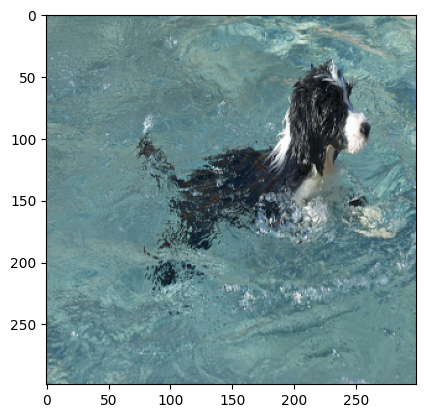

Predicted Caption:  a black and white dog is swimming in the water


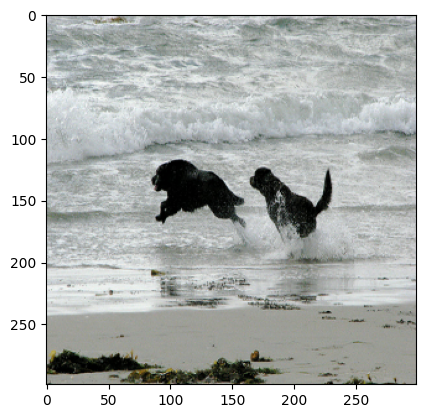

Predicted Caption:  a black dog is running on the beach


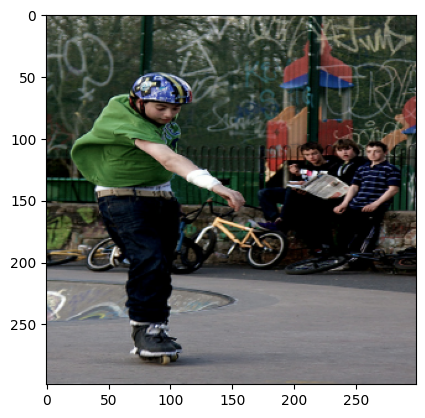

Predicted Caption:  a man in a green shirt and helmet riding a bicycle


In [59]:
# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

## Save and Load

In [60]:
%%time

caption_model.save_weights('tf_keras_image_captioning_cnn+transformer_flicker8k', save_format="tf")

CPU times: user 733 ms, sys: 330 ms, total: 1.06 s
Wall time: 1.08 s


In [21]:
# cnn_model = get_cnn_model()
# encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
# decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
newly_loaded_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

In [62]:
os.chdir("/content/test")

In [63]:
newly_loaded_model.load_weights('tf_keras_image_captioning_cnn+transformer_flicker8k')

In [65]:
from PIL import Image

In [66]:
pil_image = Image.open('/content/cat.jpeg')

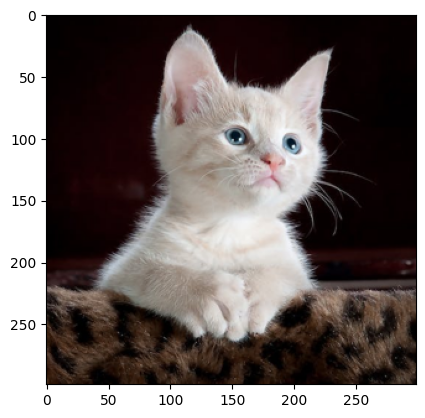

In [86]:
plt.imshow(np.asarray(pil_image.resize((299, 299))))

In [89]:
def generate_caption(caption_model, img):

    # Pass the image to the CNN
    img = np.asarray(img.resize((299, 299))).reshape((1, 299, 299, 3))
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

In [90]:
generate_caption(caption_model=newly_loaded_model, img=pil_image)

Predicted Caption:  a small white dog is jumping over a pile of wood


## End Notes

We saw that the model starts to generate reasonable captions after a few epochs. To keep
this example easily runnable, we have trained it with a few constraints, like a minimal
number of attention heads. To improve the predictions, you can try changing these training
settings and find a good model for your use case.